In [1]:
%pip install -q pandas -q scikit-learn -q lightgbm -q joblib

Note: you may need to restart the kernel to use updated packages.


In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, precision_recall_curve, auc
import joblib
import matplotlib.pyplot as plt
import numpy as np

In [6]:
df = pd.read_parquet('diabetes.parquet')

In [7]:
df['gender'] = df['gender'].map({'female': 0, 'male': 1})
df['smoking_history'] = df['smoking_history'].map({
    'never': 0, 'former': 1, 'current': 2, 'ever': 3, 'not current': 4, 'No Info': 5})

In [8]:
X = df.drop(columns=['diabetes'])
y = df['diabetes']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
train_data = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'random_state': 42
}
model = lgb.train(params, train_data, num_boost_round=100)

[LightGBM] [Info] Number of positive: 6761, number of negative: 70155
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 409
[LightGBM] [Info] Number of data points in the train set: 76916, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.087901 -> initscore=-2.339536
[LightGBM] [Info] Start training from score -2.339536


In [41]:
#model = joblib.load('modelo_diabetes_lightgbm.pkl')

In [55]:
y_pred_prob = model.predict(X_test)
threshold = 0.38
y_pred = [1 if prob > threshold else 0 for prob in y_pred_prob]

In [56]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

report = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy:.2f}')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print("\nRelatório de Classificação:\n", report)

Acurácia: 0.97
Precisão: 0.94
Recall: 0.71
F1 Score: 0.81

Relatório de Classificação:
               precision    recall  f1-score   support

       False       0.97      1.00      0.98     17509
        True       0.94      0.71      0.81      1721

    accuracy                           0.97     19230
   macro avg       0.96      0.85      0.90     19230
weighted avg       0.97      0.97      0.97     19230



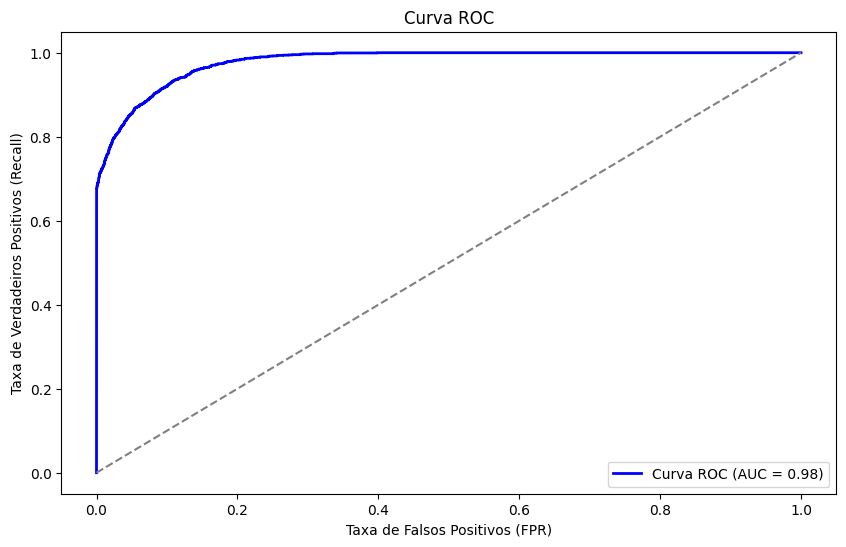

In [57]:
# Curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

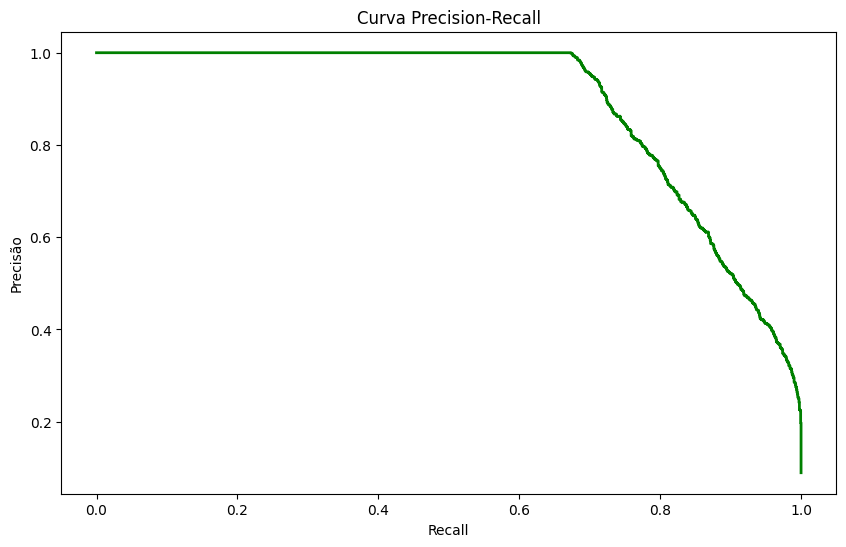

In [58]:
# Curva Precision-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva Precision-Recall')
plt.show()

In [59]:
# Encontrar o threshold
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds_pr[best_threshold_index]

print(f"Melhor Threshold (baseado no F1-Score): {best_threshold:.2f}")

Melhor Threshold (baseado no F1-Score): 0.38


In [60]:
joblib.dump(model, 'modelo_diabetes_lightgbm.pkl')
print('Modelo exportado com sucesso!')

Modelo exportado com sucesso!
